In [1]:
from pathlib import Path # 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import geopandas as gpd
import pandas as pd
import tfv.xarray
import xarray as xr  
from tfv.extractor import FvExtractor
from tfv.timeseries import FvTimeSeries
from shapely import wkt
# A nice plot default
sns.set(style='white', font_scale=0.8)

In [2]:
# Use the correct DBFS path for the shared volume
model_folder = Path('/Projects2/csiem/model/csiem_model_tfvaed_1.6/outputs/results/')
model_file = 'csiem_B009_20221101_20240401_WQ_WQ.nc'
ds = xr.open_dataset(model_folder/model_file, decode_times=True, engine='netcdf4')
fv = ds.tfv
fv

<xarray.Dataset> Size: 3TB
Dimensions:                        (Time: 3091, NumLayerFaces3D: 534016,
                                    NumCells2D: 30206, NumCells3D: 503810)
Coordinates:
  * Time                           (Time) datetime64[ns] 25kB 2022-11-02 ... ...
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables: (12/444)
    ResTime                        (Time) datetime64[ns] 25kB 2022-11-02 ... ...
    layerface_Z                    (Time, NumLayerFaces3D) float32 7GB ...
    stat                           (Time, NumCells2D) int32 373MB ...
    H                              (Time, NumCells2D) float32 373MB ...
    D                              (Time, NumCells2D) float32 373MB ...
    V_x                            (Time, NumCells3D) float32 6GB ...
    ...                             ...
    WQ_DIAG_OAS_A_IOP3_BAND16      (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_A_IOP4_BAND16      (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_A_BAND16           (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_B_BAND16           (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_KD                 (Time, NumCells3D) float32 6GB ...
    WQ_DIAG_OAS_SECCHI             (Time, NumCells3D) float32 6GB ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

TUFLOW FV domain xarray accessor object

In [3]:
import geopandas as gpd
import pandas as pd

# Load the shapefile
shp_path = r"../../gis/Curtain/New_Curtain_line_LL_100m.shp"
gdf = gpd.read_file(shp_path)
# Make sure the CRS is geographic (lat/lon)
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)

# Extract coordinates
gdf["longitude"] = gdf.geometry.x
gdf["latitude"]  = gdf.geometry.y

# Drop the geometry column if you want just lat/lon + attributes
df = gdf.drop(columns="geometry")
polyline = df[['longitude', 'latitude']].to_numpy()


Text(0.98, 0.95, 'S')

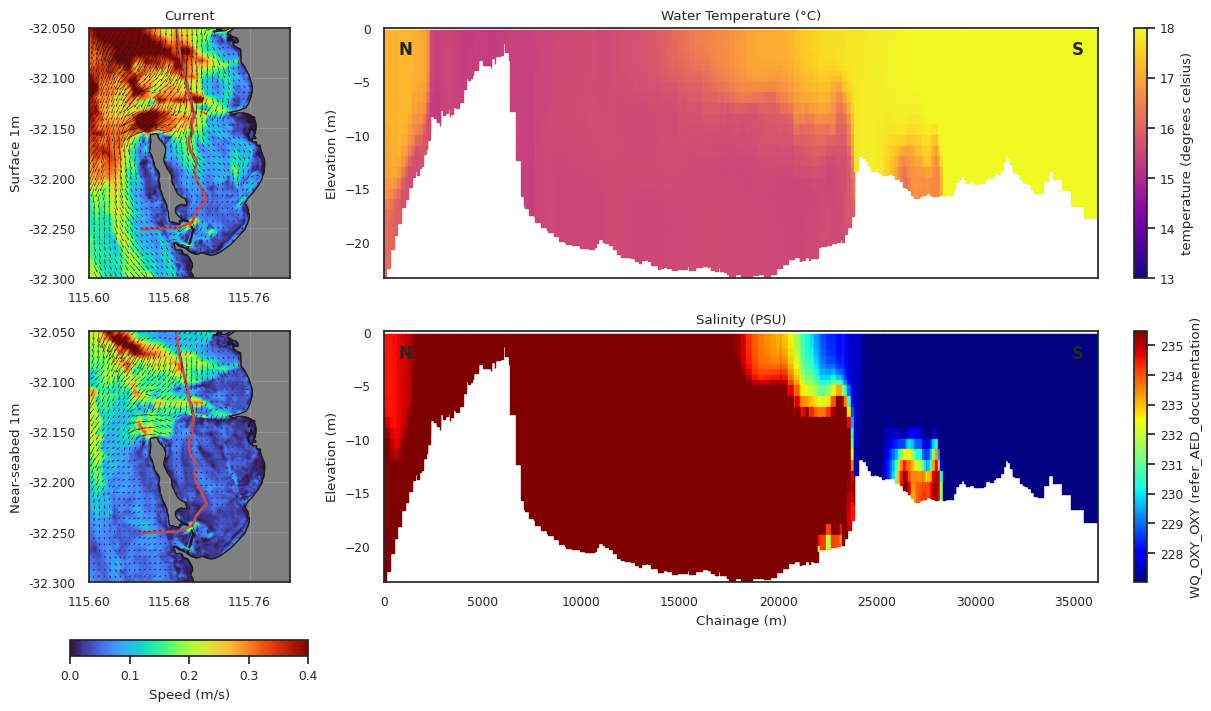

In [5]:

import matplotlib.ticker as mticker  # Helps set tick positions
vel_spec = dict(cmap='turbo', clim=(0, 0.40), shading='interp', colorbar=False, boundary=True)
sal_spec = dict(cmap='ocean', clim=(35.5, 37.5), shading='interp', colorbar=False, boundary=True)
temp_spec = dict(cmap='YlOrRd', clim=(21, 24), shading='interp', colorbar=False, boundary=True)

titles = {0: 'Current', 1: 'Temperature Curtain', 2: 'Salinity Curtain'}
ylabels = {0: 'Surface 1m', 1: 'Near-seabed 1m', 2: 'Depth-averaged'}

time = '2023-07-01 20:00'
bbox = (115.60, -32.30, 115.80, -32.05)  # Focus on specific area
zoom = bbox  # Use zoom parameter for fv.plot()

sns.set_theme(style='white', font_scale=0.8)

# Right columns: 2 equal-height curtain plots
fig = plt.figure(figsize=(12, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Left column - Current plots (2 rows)
ax_curr_surf = fig.add_subplot(gs[0, 0])  # Surface current
ax_curr_bot = fig.add_subplot(gs[1, 0])   # Bottom current  

# Right columns - Curtain plots (equal height, spanning 3 columns each)
ax_temp_curtain = fig.add_subplot(gs[0, 1:4])  # Temperature curtain (top half)
ax_sal_curtain = fig.add_subplot(gs[1, 1:4])   # Salinity curtain (bottom half)

# Store axes for easy iteration
current_axes = [ax_curr_surf, ax_curr_bot]
curtain_axes = [ax_temp_curtain, ax_sal_curtain]

# Set background color to grey for current plot axes
for ax in current_axes:
    ax.set_facecolor('grey')

# Current plots in left column
# Surface current
c1 = fv.plot('V', time, ax=ax_curr_surf, datum='depth', **vel_spec)
v1 = fv.plot_vector('V', time, ax=ax_curr_surf, datum='depth', color='k', scale=5)
ax_curr_surf.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Bottom current
fv.plot('V', time, ax=ax_curr_bot, datum='height', **vel_spec)
v2 = fv.plot_vector('V', time, ax=ax_curr_bot, datum='height', color='k', scale=5)
ax_curr_bot.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Set axis limits for current plots
for ax in current_axes:
    ax.set_xlim(bbox[0], bbox[2])  # west, east
    ax.set_ylim(bbox[1], bbox[3])  # south, north
# Curtain plots in right columns
# Temperature curtain
fv.plot_curtain(
    polyline,
    "TEMP",
    time=time,
    ax=ax_temp_curtain, 
    ec="face",  # edgecolor
    cmap="plasma",  # for temperature
    clim=(13, 18),   # temperature limits
)

# Salinity curtain
fv.plot_curtain(
    polyline,
    "WQ_OXY_OXY",
    time=time,
    ax=ax_sal_curtain, 
    ec="face",  # edgecolor
    cmap="jet",  # for salinity
 #   clim=(35.8, 36.2),   # salinity limits
)

# Format current plot axes
for i, ax in enumerate(current_axes):
    # Common settings
    ax.set_aspect('equal')
    ax.grid(True, color='darkgrey', alpha=0.7, linewidth=0.5)
    
    # Limit ticks
    ax.xaxis.set_major_locator(mticker.MaxNLocator(3))
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([f'{x:0.2f}' for x in ticks_loc])
    
    # Set labels
    ax.set_ylabel(ylabels[i])
    if i == 0:
        ax.set_title('Current')
    else:
        ax.set_title('')

# Format curtain plot axes
ax_temp_curtain.set_title('Water Temperature (°C)')
ax_temp_curtain.set_xlabel("")       # remove "Chainage (m)"
ax_temp_curtain.tick_params(labelbottom=False)
ax_temp_curtain.set_xticks([])

# Add N, S labels to curtain plots
ax_temp_curtain.text(0.02, 0.95, 'N', transform=ax_temp_curtain.transAxes, fontsize=12, fontweight='bold', va='top')

ax_temp_curtain.text(0.98, 0.95, 'S', transform=ax_temp_curtain.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.colorbar(c1.patch, ax=ax_curr_bot, orientation='horizontal', label='Speed (m/s)', aspect=15)

ax_sal_curtain.set_title('Salinity (PSU)')# Add colorbars

ax_sal_curtain.text(0.02, 0.95, 'N', transform=ax_sal_curtain.transAxes, fontsize=12, fontweight='bold', va='top')
ax_sal_curtain.text(0.98, 0.95, 'S', transform=ax_sal_curtain.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

Text(0.98, 1.07, 'S')

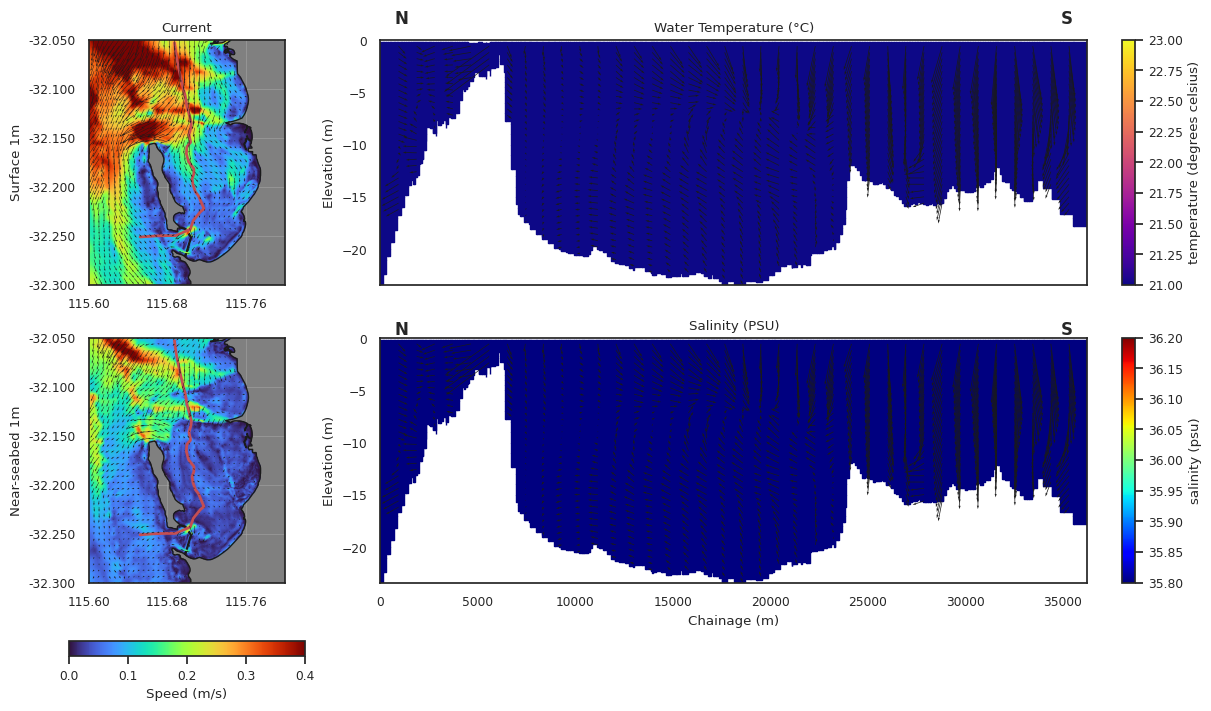

In [6]:
import matplotlib.ticker as mticker  # Helps set tick positions
vel_spec = dict(cmap='turbo', clim=(0, 0.40), shading='interp', colorbar=False, boundary=True)
sal_spec = dict(cmap='ocean', clim=(35.5, 37.5), shading='interp', colorbar=False, boundary=True)
temp_spec = dict(cmap='YlOrRd', clim=(21, 24), shading='interp', colorbar=False, boundary=True)

titles = {0: 'Current', 1: 'Temperature Curtain', 2: 'Salinity Curtain'}
ylabels = {0: 'Surface 1m', 1: 'Near-seabed 1m', 2: 'Depth-averaged'}

time = '2023-07-01 20:00'
bbox = (115.60, -32.30, 115.80, -32.05)  # Focus on specific area
zoom = bbox  # Use zoom parameter for fv.plot()

sns.set_theme(style='white', font_scale=0.8)

# Create custom subplot layout: 2 rows, 4 columns 
# Left column (2 subplots): Current plots
# Right columns: 2 equal-height curtain plots
fig = plt.figure(figsize=(12, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Left column - Current plots (2 rows)
ax_curr_surf = fig.add_subplot(gs[0, 0])  # Surface current
ax_curr_bot = fig.add_subplot(gs[1, 0])   # Bottom current  

# Right columns - Curtain plots (equal height, spanning 3 columns each)
ax_temp_curtain = fig.add_subplot(gs[0, 1:4])  # Temperature curtain (top half)
ax_sal_curtain = fig.add_subplot(gs[1, 1:4])   # Salinity curtain (bottom half)

# Store axes for easy iteration
current_axes = [ax_curr_surf, ax_curr_bot]
curtain_axes = [ax_temp_curtain, ax_sal_curtain]

# Set background color to grey for current plot axes
for ax in current_axes:
    ax.set_facecolor('grey')

# Current plots in left column
# Surface current
c1 = fv.plot('V', time, ax=ax_curr_surf, datum='depth', **vel_spec)
v1 = fv.plot_vector('V', time, ax=ax_curr_surf, datum='depth', color='k', scale=5)
ax_curr_surf.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Bottom current
fv.plot('V', time, ax=ax_curr_bot, datum='height', **vel_spec)
v2 = fv.plot_vector('V', time, ax=ax_curr_bot, datum='height', color='k', scale=5)
ax_curr_bot.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Set axis limits for current plots
for ax in current_axes:
    ax.set_xlim(bbox[0], bbox[2])  # west, east
    ax.set_ylim(bbox[1], bbox[3])  # south, north
# Curtain plots in right columns
# Temperature curtain
fv.plot_curtain(
    polyline,
    "TEMP",
    time=time,
    ax=ax_temp_curtain, 
    ec="face",  # edgecolor
    cmap="plasma",  # for temperature
    clim=(21, 23),   # temperature limits
)
# Overlay velocity vectors on temperature curtain
fv.plot_curtain_vector(
    polyline,
    time=time,
    tangential=False,   # ensures W is shown without projection scaling
    ax=ax_temp_curtain,
    scale=5,            # adjust arrow scaling
    color="k",          # vector color (black arrows)
    width=0.001,        # arrow thickness
)
# Salinity curtain
fv.plot_curtain(
    polyline,
    "SAL",
    time=time,
    ax=ax_sal_curtain, 
    ec="face",  # edgecolor
    cmap="jet",  # for salinity
    clim=(35.8, 36.2),   # salinity limits
)

# Overlay velocity vectors on salinity curtain 
fv.plot_curtain_vector(
    polyline,
    time=time,
    tangential=False,   # ensures W is shown without projection scaling
    ax=ax_sal_curtain,
    scale=5,            # adjust arrow scaling
    color="k",          # vector color (black arrows)
    width=0.001,        # arrow thickness
)

# Format current plot axes
for i, ax in enumerate(current_axes):
    # Common settings
    ax.set_aspect('equal')
    ax.grid(True, color='darkgrey', alpha=0.7, linewidth=0.5)
    
    # Limit ticks
    ax.xaxis.set_major_locator(mticker.MaxNLocator(3))
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([f'{x:0.2f}' for x in ticks_loc])
    
    # Set labels
    ax.set_ylabel(ylabels[i])
    if i == 0:
        ax.set_title('Current')
    else:
        ax.set_title('')

# Format curtain plot axes
ax_temp_curtain.set_title('Water Temperature (°C)')
ax_temp_curtain.set_xlabel("")       # remove "Chainage (m)"
ax_temp_curtain.tick_params(labelbottom=False)
ax_temp_curtain.set_xticks([])

# Add N, S labels to curtain plots
ax_temp_curtain.text(0.02, 1.05, 'N', transform=ax_temp_curtain.transAxes, fontsize=12, fontweight='bold', va='bottom')
ax_temp_curtain.text(0.98, 1.05, 'S', transform=ax_temp_curtain.transAxes, fontsize=12, fontweight='bold', va='bottom', ha='right')

plt.colorbar(c1.patch, ax=ax_curr_bot, orientation='horizontal', label='Speed (m/s)', aspect=15)

ax_sal_curtain.set_title('Salinity (PSU)')# Add colorbars

ax_sal_curtain.text(0.02, 1.07, 'N', transform=ax_sal_curtain.transAxes, fontsize=12, fontweight='bold', va='top')
ax_sal_curtain.text(0.98, 1.07, 'S', transform=ax_sal_curtain.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

Creating animation with 24 frames...
Saving animation to outputs/curtain_4panel_animation_2023-12-OXY.gif...
✅ Animation saved successfully to outputs/curtain_4panel_animation_2023-12-OXY.gif


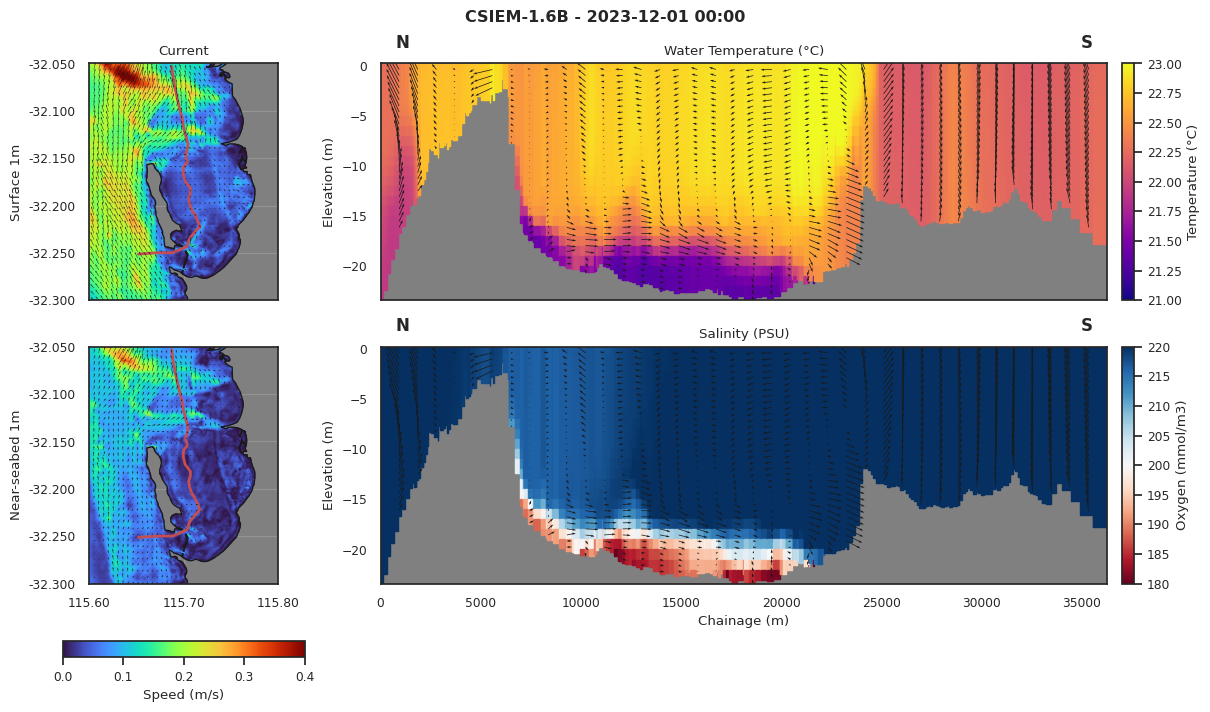

In [ ]:
from matplotlib import animation

# --- Output setup ---
output_folder = Path('./outputs')
output_folder.mkdir(exist_ok=True)
out_file_gif = output_folder / 'curtain_4panel_animation_2023-12-OXY.gif'

# --- Time range for animation ---
time_start = '2023-12-01 00:00'
time_end = '2023-12-04 23:00'  # 24 hours
fvx = fv.sel(Time=slice(time_start, time_end))

# --- Plot style settings ---
sns.set_theme(style='white', font_scale=0.8)
vel_spec_anim = dict(cmap='turbo', clim=(0, 0.40), shading='interp',
                     colorbar=False, boundary=True)
bbox = (115.60, -32.30, 115.80, -32.05)

# --- Figure layout ---
fig = plt.figure(figsize=(12, 7), constrained_layout=True)
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

# Left column - Current plots
ax_curr_surf = fig.add_subplot(gs[0, 0])
ax_curr_bot = fig.add_subplot(gs[1, 0])

# Right columns - Curtain plots
ax_temp_curtain = fig.add_subplot(gs[0, 1:4])
ax_sal_curtain = fig.add_subplot(gs[1, 1:4])

current_axes = [ax_curr_surf, ax_curr_bot]
ylabels_anim = {0: 'Surface 1m', 1: 'Near-seabed 1m'}

# --- Backgrounds ---
for ax in current_axes:
    ax.set_facecolor('grey')
ax_temp_curtain.set_facecolor('grey')
ax_sal_curtain.set_facecolor('grey')

# --- Initial frame (frame 0) ---
# Surface current
sheet_surf = fvx.plot('V', 0, ax=ax_curr_surf, datum='depth', **vel_spec_anim)
vec_surf = fvx.plot_vector('V', 0, ax=ax_curr_surf, datum='depth', color='k', scale=5)
ax_curr_surf.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Bottom current  
sheet_bot = fvx.plot('V', 0, ax=ax_curr_bot, datum='height', **vel_spec_anim)
vec_bot = fvx.plot_vector('V', 0, ax=ax_curr_bot, datum='height', color='k', scale=5)
ax_curr_bot.plot(polyline[:, 0], polyline[:, 1], 'r-', linewidth=2)

# Temperature curtain
temp_curtain = fvx.plot_curtain(
    polyline, "TEMP", 0, ax=ax_temp_curtain,
    ec="face", cmap="plasma", clim=(21, 23), colorbar=False
)
cbar_temp = fig.colorbar(temp_curtain.patch, ax=ax_temp_curtain,
                         orientation="vertical", fraction=0.025, pad=0.02)
cbar_temp.set_label("Temperature (°C)")

# Salinity curtain
sal_curtain = fvx.plot_curtain(
    polyline, "WQ_OXY_OXY", 0, ax=ax_sal_curtain,
    ec="face", cmap="RdBu", clim=(180, 220), colorbar=False
)
cbar_sal = fig.colorbar(sal_curtain.patch, ax=ax_sal_curtain,
                        orientation="vertical", fraction=0.025, pad=0.02)
cbar_sal.set_label("Oxygen (mmol/m3)")

# Velocity vectors on curtains
temp_vec = fvx.plot_curtain_vector(polyline, 0, ax=ax_temp_curtain,
                                   tangential=False, scale=5, color="k", width=0.001)
sal_vec = fvx.plot_curtain_vector(polyline, 0, ax=ax_sal_curtain,
                                  tangential=False, scale=5, color="k", width=0.001)

# --- Format current plot axes ---
for i, ax in enumerate(current_axes):
    ax.set_aspect('equal')
    ax.grid(True, color='darkgrey', alpha=0.7, linewidth=0.5)

    # Fixed ticks: first, middle, last
    x_min, x_max = bbox[0], bbox[2]
    x_ticks = [x_min, (x_min + x_max) / 2, x_max]
    ax.xaxis.set_major_locator(mticker.FixedLocator(x_ticks))
    ax.set_xticklabels([f'{x:0.2f}' for x in x_ticks])

    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])
    ax.set_ylabel(ylabels_anim[i])

    if i == 0:
        ax.set_title('Current')
    else:
        ax.set_title('')
    if i != 1:
        ax.set_xticklabels([])

# --- Format curtain plots ---
ax_temp_curtain.set_title('Water Temperature (°C)')
ax_temp_curtain.set_xlabel("")
ax_temp_curtain.tick_params(labelbottom=False)
ax_temp_curtain.set_xticks([])

# Custom x-ticks (from your MATLAB definition)
xticks = [1000, 6000, 17060, 25000, 35000]
xticklabels = ['Sepia Depression', 'Causeway', 'Central Basin', 'Parmelia Bank', 'Fremantle']
ax_sal_curtain.set_xticks(xticks)
ax_sal_curtain.set_xticklabels(xticklabels, rotation=0, fontsize=9)


ax_sal_curtain.set_title('Salinity (PSU)')

# Add N/S labels
ax_temp_curtain.text(0.02, 1.05, 'N', transform=ax_temp_curtain.transAxes,
                     fontsize=12, fontweight='bold', va='bottom')
ax_temp_curtain.text(0.98, 1.05, 'S', transform=ax_temp_curtain.transAxes,
                     fontsize=12, fontweight='bold', va='bottom', ha='right')
ax_sal_curtain.text(0.02, 1.05, 'N', transform=ax_sal_curtain.transAxes,
                    fontsize=12, fontweight='bold', va='bottom')
ax_sal_curtain.text(0.98, 1.05, 'S', transform=ax_sal_curtain.transAxes,
                    fontsize=12, fontweight='bold', va='bottom', ha='right')

# --- Colorbar for currents ---
plt.colorbar(sheet_surf.patch, ax=ax_curr_bot, orientation='horizontal',
             label='Speed (m/s)', aspect=15)

# --- Animation function ---
def animate(i):
    sheet_surf.set_time_current(i)
    vec_surf.set_time_current(i)
    sheet_bot.set_time_current(i)
    vec_bot.set_time_current(i)

    temp_curtain.set_time_current(i)
    sal_curtain.set_time_current(i)
    temp_vec.set_time_current(i)
    sal_vec.set_time_current(i)

    date = sheet_surf.get_time_current()
    fig.suptitle(f'CSIEM-1.6B - {date.strftime("%Y-%m-%d %H:%M")}',
                 fontweight='bold')

# --- Create animation ---
nframes = fvx.sizes['Time']
print(f"Creating animation with {nframes} frames...")

anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, interval=200)

# --- Save animation as GIF (Pillow writer) ---
print(f"Saving animation to {out_file_gif}...")
writer = animation.PillowWriter(fps=2)
anim.save(out_file_gif, writer=writer, dpi=300)
print(f"✅ Animation saved successfully to {out_file_gif}")
